# SDoH Extractor and Clinical Data Annotation (Python + R)

### Project Scope:

Adverse social determinants of health (SDoH), like food insecurity and housing instability, contribute to poor health outcomes, but studying these links is difficult because SDoH details are often found in free-text clinical notes rather than structured data. As a result, there is increasing interest in developing automated methods to extract this information. Methods like Natural Language Processing (NLP) and machine learning use existing health IT systems to scan unstructured data in electronic health records (EHRs) and enable automated extraction of social determinants of health (SDoH).

In this project, we are developing a Python-based tool to extract social determinants of health (SDoH), such as housing, employment, and social support, from synthetic clinical notes using rule-based natural language processing (NLP) techniques. Additionally, we are implementing a basic R algorithm for data annotation to generate a JSON dataset compatible with the SpaCy model.




### Step 1: Set up environment

In [44]:
#import Packages
import pandas as pd
import random
import json

from faker import Faker  #data generation

import spacy       #SDOH extraction
from spacy.matcher import PhraseMatcher
from spacy.training import Example #model training

from sklearn.metrics import precision_recall_fscore_support  #Performance metrics

from spacy.training import offsets_to_biluo_tags         #Test data annotation

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt



### Step 2: Generate Synthetic Canadian Clinical Notes

In this step, we use Faker to create 500 synthetic notes. The synthetic notes are simpler than real notes with less variation.

In [45]:
# Initialize Faker with Canadian locale
fake = Faker('en_CA')

# SDoH templates
templates = [
    "{name}, a {age}-year-old {gender} from {city}, {province}, reports {housing_status}.",
    "{name} presents with {health_issue}. Notes {employment_status} and {social_support}.",
    "{name} is a {age}-year-old {gender}. Reports {substance_use} and {housing_status}.",
    "{name} is a {age}-year-old {social_status} in {city}. Reports {substance_use}. Currently {employment_status}",
]

housing_statuses = ["living in a shelter", "stable housing", "facing eviction", "homeless"]
employment_statuses = ["unemployed", "employed part-time", "retired", "on disability", "employed full-time"]
social_supports = ["no family support", "lives with family", "strong community ties"]
substance_uses = ["no substance use", "smokes tobacco", "uses alcohol heavily"]
health_issues = ["hypertension", "diabetes", "anxiety", "stable health", "depression"]
social_status = ["widow", "single mother", "divorced", "married", "single"]

# Generate synthetic notes
notes = []
for _ in range(500):
    name = fake.name()
    age = random.randint(18, 80)
    gender = random.choice(["male", "female", "non-binary"])
    city = fake.city()
    province = fake.province()
    template = random.choice(templates)
    note = template.format(
        name=name,
        age=age,
        gender=gender,
        city=city,
        province=province,
        housing_status=random.choice(housing_statuses),
        employment_status=random.choice(employment_statuses),
        social_support=random.choice(social_supports),
        substance_use=random.choice(substance_uses),
        health_issue=random.choice(health_issues),
        social_status=random.choice(social_status)
    )
    notes.append({"note": note, "name": name, "age": age, "city": city})

# Save to DataFrame
df = pd.DataFrame(notes)
df.to_csv("synthetic_notes.csv", index=False)

### Step 3: Extract SDoH Using Rule-Based NLP

Rule-based systems use predefined patterns to extract information from text, offering speed and reliability but requiring significant effort to maintain. For instance, such systems can identify entities like people or diseases based on features like capitalization or specific keywords.

In [58]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")
matcher = PhraseMatcher(nlp.vocab)

# Define SDoH patterns
housing_patterns = [nlp(text) for text in ["living in a shelter", "stable housing", "facing eviction", "homeless"]]
employment_patterns = [nlp(text) for text in ["unemployed", "employed part-time", "retired", "on disability", "employed full-time"]]
social_patterns = [nlp(text) for text in ["no family support", "lives with family", "strong community ties"]]
social_patterns2 = [nlp(text) for text in ["widow", "single mother", "divorced", "married", "single"]]
social_patterns3 = [nlp(text) for text in ["no substance use", "smokes tobacco", "uses alcohol heavily"]]
health_patterns = [nlp(text) for text in ["hypertension", "diabetes", "anxiety", "stable health", "depression"]]


matcher.add("HOUSING", housing_patterns)
matcher.add("EMPLOYMENT", employment_patterns)
matcher.add("SOCIAL_SUPPORT", social_patterns)
matcher.add("SOCIAL_STATUS", social_patterns2)
matcher.add("SUBSTANCE_ABUSE", social_patterns3)
matcher.add("HEALTH_ISSUES", health_patterns)


# Function to extract SDoH
def extract_sdoh(note):
    doc = nlp(note)
    matches = matcher(doc)
    sdoh = []
    for match_id, start, end in matches:
        label = nlp.vocab.strings[match_id]
        entity = doc[start:end].text
        sdoh.append({"label": label, "entity": entity})
    return sdoh

# Apply to all notes
df["sdoh"] = df["note"].apply(extract_sdoh)

C:\Users\amany\opencv\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [47]:
#Save data frame
#df.to_csv("synthetic_notes_labelled.csv", index=False)

### Step 4: Data Visualization

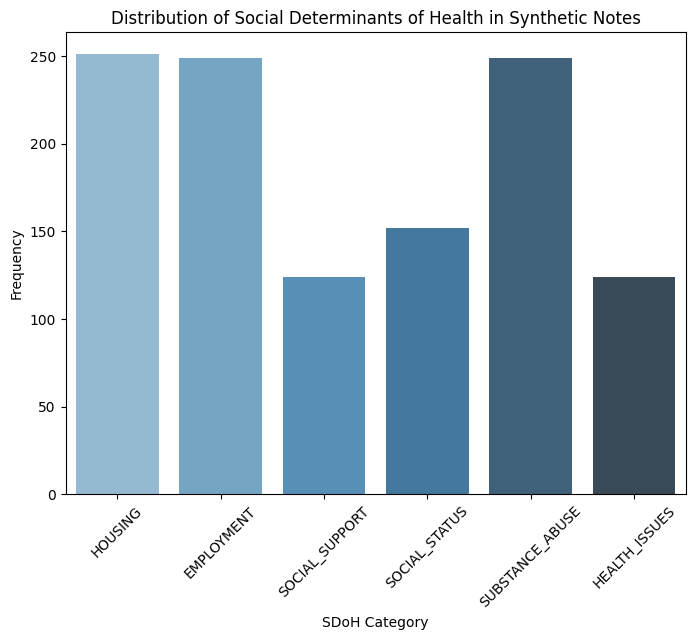

In [48]:
# Flatten SDoH data
sdoh_counts = {"HOUSING": 0, "EMPLOYMENT": 0, "SOCIAL_SUPPORT": 0, "SOCIAL_STATUS": 0, "SUBSTANCE_ABUSE": 0, "HEALTH_ISSUES": 0}
for sdoh_list in df["sdoh"]:
    for sdoh in sdoh_list:
        sdoh_counts[sdoh["label"]] += 1

# Create DataFrame for plotting
plot_data = pd.DataFrame({
    "SDoH Category": sdoh_counts.keys(),
    "Count": sdoh_counts.values()
})

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x="SDoH Category", y="Count", data=plot_data, hue="SDoH Category", palette="Blues_d")
plt.title("Distribution of Social Determinants of Health in Synthetic Notes")
plt.xlabel("SDoH Category")
plt.ylabel("Frequency")
plt.xticks(rotation = 45)
plt.savefig("sdoh_distribution.png")
plt.show()

### Step 5: Data Annotation in R

In this step, we used data processing techniques to identify start and end spans of SDOH entities. The code file (Data Annotation.Rmd) is available in the Github repository

### Step 6: Train the spaCy NER Model


We have used ScispaCy pre-trained biomedical en_core_sci_sm model to extract SDOH as a starting point. The NER component was trained for 30 iterations with dropout (0.5) to prevent overfitting.



In [50]:
# Load training data
with open("train_data.json", "r") as f:
    TRAIN_DATA = json.load(f)

# Load the base model
nlp = spacy.load("en_core_sci_sm")

# Add NER pipeline if not present
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

# Add SDoH labels
for _, annotations in TRAIN_DATA:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])  # e.g., HOUSING, EMPLOYMENT

# Disable other pipelines during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.resume_training()
    for itn in range(30):  # 30 iterations
        random.shuffle(TRAIN_DATA)
        losses = {}
        for text, annotations in TRAIN_DATA:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], drop=0.5, sgd=optimizer, losses=losses)
        print(f"Iteration {itn}, Losses: {losses}")

# Save the trained model
nlp.to_disk("sdoh_ner_model")

Iteration 0, Losses: {'ner': 920.2625846247404}
Iteration 1, Losses: {'ner': 190.02932781106813}
Iteration 2, Losses: {'ner': 67.19886360522119}
Iteration 3, Losses: {'ner': 50.78736224883153}
Iteration 4, Losses: {'ner': 70.51059561537318}
Iteration 5, Losses: {'ner': 46.771639071041015}
Iteration 6, Losses: {'ner': 41.95944366994082}
Iteration 7, Losses: {'ner': 52.97238651315199}
Iteration 8, Losses: {'ner': 48.5649119470552}
Iteration 9, Losses: {'ner': 39.33756681456616}
Iteration 10, Losses: {'ner': 39.35002637230068}
Iteration 11, Losses: {'ner': 17.827442356107913}
Iteration 12, Losses: {'ner': 39.37473923162857}
Iteration 13, Losses: {'ner': 28.731917219119264}
Iteration 14, Losses: {'ner': 29.96302171011904}
Iteration 15, Losses: {'ner': 26.618802303931027}
Iteration 16, Losses: {'ner': 24.22295747551079}
Iteration 17, Losses: {'ner': 35.97659550903534}
Iteration 18, Losses: {'ner': 48.46946277840468}
Iteration 19, Losses: {'ner': 19.029975581564152}
Iteration 20, Losses: {'n

### Step 7: Evaluate the Model


In this model, we evaluate the trained model on the test set using precision, recall, and F1-score. This is a simplified evaluation assuming one entity per note. 


In [51]:
# Load test data
with open("test_data.json", "r") as f:
    TEST_DATA = json.load(f)

# Load trained model
nlp = spacy.load("sdoh_ner_model")

# Evaluate
true_labels = []
pred_labels = []
for text, annotations in TEST_DATA:
    doc = nlp(text)
    true_ents = [(start, end, label) for start, end, label in annotations.get("entities")]
    pred_ents = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    
    # Simplify: Assume one entity per note for evaluation (adjust for multi-entity notes)
    true_labels.extend([label for _, _, label in true_ents])
    pred_labels.extend([label for _, _, label in pred_ents] if pred_ents else ["NONE"])

# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="weighted")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}")

Precision: 1.000, Recall: 1.000, F1-Score: 1.000


The metrics results are 1 mostly because there is no wide variation in data. Next step, we will use ML model and compare the results

### Step 8: Integrated ML model to existing pipeline

In [59]:
# Load trained model
nlp = spacy.load("sdoh_ner_model")

# Load synthetic notes
df2 = pd.read_csv("synthetic_notes.csv")

# Extract SDoH with ML model
def extract_sdoh_ml(note):
    doc = nlp(note)
    return [{"label": ent.label_, "entity": ent.text} for ent in doc.ents]

df2["sdoh_ml"] = df2["note"].apply(extract_sdoh_ml)

### Step 9: Visualize and Compare Results


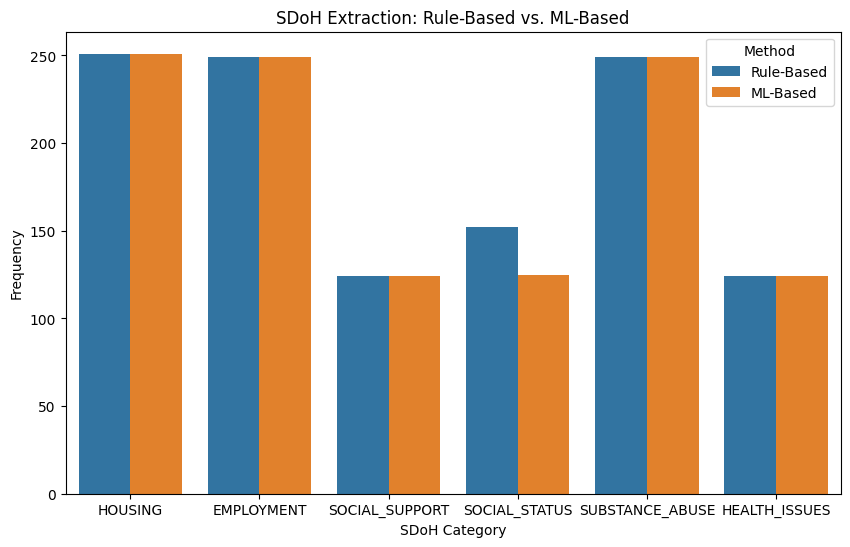

In [60]:
# Count SDoH from rule-based and ML-based methods
rule_counts = {"HOUSING": 0, "EMPLOYMENT": 0, "SOCIAL_SUPPORT": 0, "SOCIAL_STATUS": 0, "SUBSTANCE_ABUSE": 0, "HEALTH_ISSUES": 0}
ml_counts = {"HOUSING": 0, "EMPLOYMENT": 0, "SOCIAL_SUPPORT": 0, "SOCIAL_STATUS": 0, "SUBSTANCE_ABUSE": 0, "HEALTH_ISSUES": 0}

for sdoh_list in df["sdoh"]:  # Rule-based
    for sdoh in sdoh_list:
        rule_counts[sdoh["label"]] += 1
for sdoh_list in df2["sdoh_ml"]:  # ML-based
    for sdoh in sdoh_list:
        ml_counts[sdoh["label"]] += 1

# Create DataFrame for plotting
plot_data = pd.DataFrame([
    {"Method": "Rule-Based", "SDoH": k, "Count": v} for k, v in rule_counts.items()
] + [
    {"Method": "ML-Based", "SDoH": k, "Count": v} for k, v in ml_counts.items()
])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="SDoH", y="Count", hue="Method", data=plot_data)
plt.title("SDoH Extraction: Rule-Based vs. ML-Based")
plt.xlabel("SDoH Category")
plt.ylabel("Frequency")
plt.savefig("sdoh_comparison.png")
plt.show()

The results of rule-based and ML-based models are quite similar.

### GOOD PRACTICES FOR DATA ANNOTATION

It is important to ensure that the annotated data perfectly aligns with the Spacy model. 

#### 1- Example of non-aligned data

In [62]:
import spacy

nlp = spacy.blank("en")
text = "Charles Sharp, a 42-year-old non-binary from New Robertstad, Yukon Territory, reports stable housing."
entities = [(86, 99, "HOUSING")]  # Example span

doc = nlp.make_doc(text)
tags = offsets_to_biluo_tags(doc, [(start, end, label) for start, end, label in entities])
print(tags)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '-', '-', 'O']


C:\Users\amany\opencv\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Charles Sharp, a 42-year-old non-binary from New R..." with entities "[(86, 99, 'HOUSING')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


If the character (-) appears, it means that Spacy could not align the model.

#### 2- Check How Spacy identify the entity span

In [63]:
for i, token in enumerate(doc):
    print(f"{i}: '{token.text}' [{token.idx}, {token.idx + len(token.text)}]")


0: 'Charles' [0, 7]
1: 'Sharp' [8, 13]
2: ',' [13, 14]
3: 'a' [15, 16]
4: '42' [17, 19]
5: '-' [19, 20]
6: 'year' [20, 24]
7: '-' [24, 25]
8: 'old' [25, 28]
9: 'non' [29, 32]
10: '-' [32, 33]
11: 'binary' [33, 39]
12: 'from' [40, 44]
13: 'New' [45, 48]
14: 'Robertstad' [49, 59]
15: ',' [59, 60]
16: 'Yukon' [61, 66]
17: 'Territory' [67, 76]
18: ',' [76, 77]
19: 'reports' [78, 85]
20: 'stable' [86, 92]
21: 'housing' [93, 100]
22: '.' [100, 101]


The results show that stable housing entity starts at 86 and end with 100. In this case, data processing method should be reviewed

#### 3- Repeat with the accurate Spacy span.

In [64]:
nlp = spacy.blank("en")
text = "Charles Sharp, a 42-year-old non-binary from New Robertstad, Yukon Territory, reports stable housing."
entities = [(86, 100, "HOUSING")]  # Example span

doc = nlp.make_doc(text)
tags = offsets_to_biluo_tags(doc, [(start, end, label) for start, end, label in entities])
print(tags)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-HOUSING', 'L-HOUSING', 'O']


Now the Spacy model can align the data perfectly

### References

Lituiev, D. S., Lacar, B., Pak, S., Abramowitsch, P. L., De Marchis, E. H., & Peterson, T. A. (2023). Automatic extraction of social determinants of health from medical notes of chronic lower back pain patients. Journal of the American Medical Informatics Association, 30(8), 1438-1447.

Sarbani. Extracting Medical Information From Clinical Text With NLP. Analytics Vidhya. Accessed from: https://www.analyticsvidhya.com/blog/2023/02/extracting-medical-information-from-clinical-text-with-nlp/